In [1]:
import numpy
import pandas
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from operator import itemgetter
from matplotlib import pyplot
from yellowbrick.features import ParallelCoordinates
from yellowbrick.style.palettes import PALETTES
from scipy.stats import chi2_contingency

/Users/caihuiying/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read in the data
f_data = "essays_comp_cor>.1_Chinese.csv"
data = pandas.read_csv(f_data)
# Get the linguistic complexity feature matrix for later clustering
FT_nms = list(data.columns)[4:]
LC_data = data.to_numpy()[:, 4:]
# Standardize the data
LC_data_STD = scale(LC_data)

In [3]:
# Perform PCA on the standardized data
pca = PCA(n_components=0.6)
pca.fit(LC_data_STD)
# Get the loading matrix for interpretation
loadings = pandas.DataFrame(pca.components_.T, 
                        columns=["PC{}".format(i) 
                                 for i in range(1,len(pca.components_)+1)], 
                        index=FT_nms)
# Write the loading matrix to a CSV file
#loadings.to_csv("PC_loadings.csv")

# Check the total variance explained by the resulted components
print("Total variance explained by the first {} components:".format(
    loadings.shape[1]), sum(pca.explained_variance_ratio_[:loadings.shape[1]]))

Total variance explained by the first 6 components: 0.6204656621270515


In [4]:
# Retain the four components, which are interpretable 
n_components = 4
# Check the total variance explained by the first n components
print("Total variance explained by the first {} components:".format(
    n_components), sum(pca.explained_variance_ratio_[:n_components]))
# Flip the sign of the first component to faciliate interpretation
pca.components_[0, :] = -pca.components_[0, :]
# Transform the data into PC scores
LC_data_trans = pca.transform(LC_data_STD)[:, :n_components]
# Write the transformed data to a CSV file
#pandas.DataFrame(LC_data_trans, columns=["LexSoph", "LexDiv", "numpyComp", "CLComp"], 
#             index=list(data["ID"])).to_csv("your_PC_data_file_name.csv")

Total variance explained by the first 4 components: 0.5192919170464838


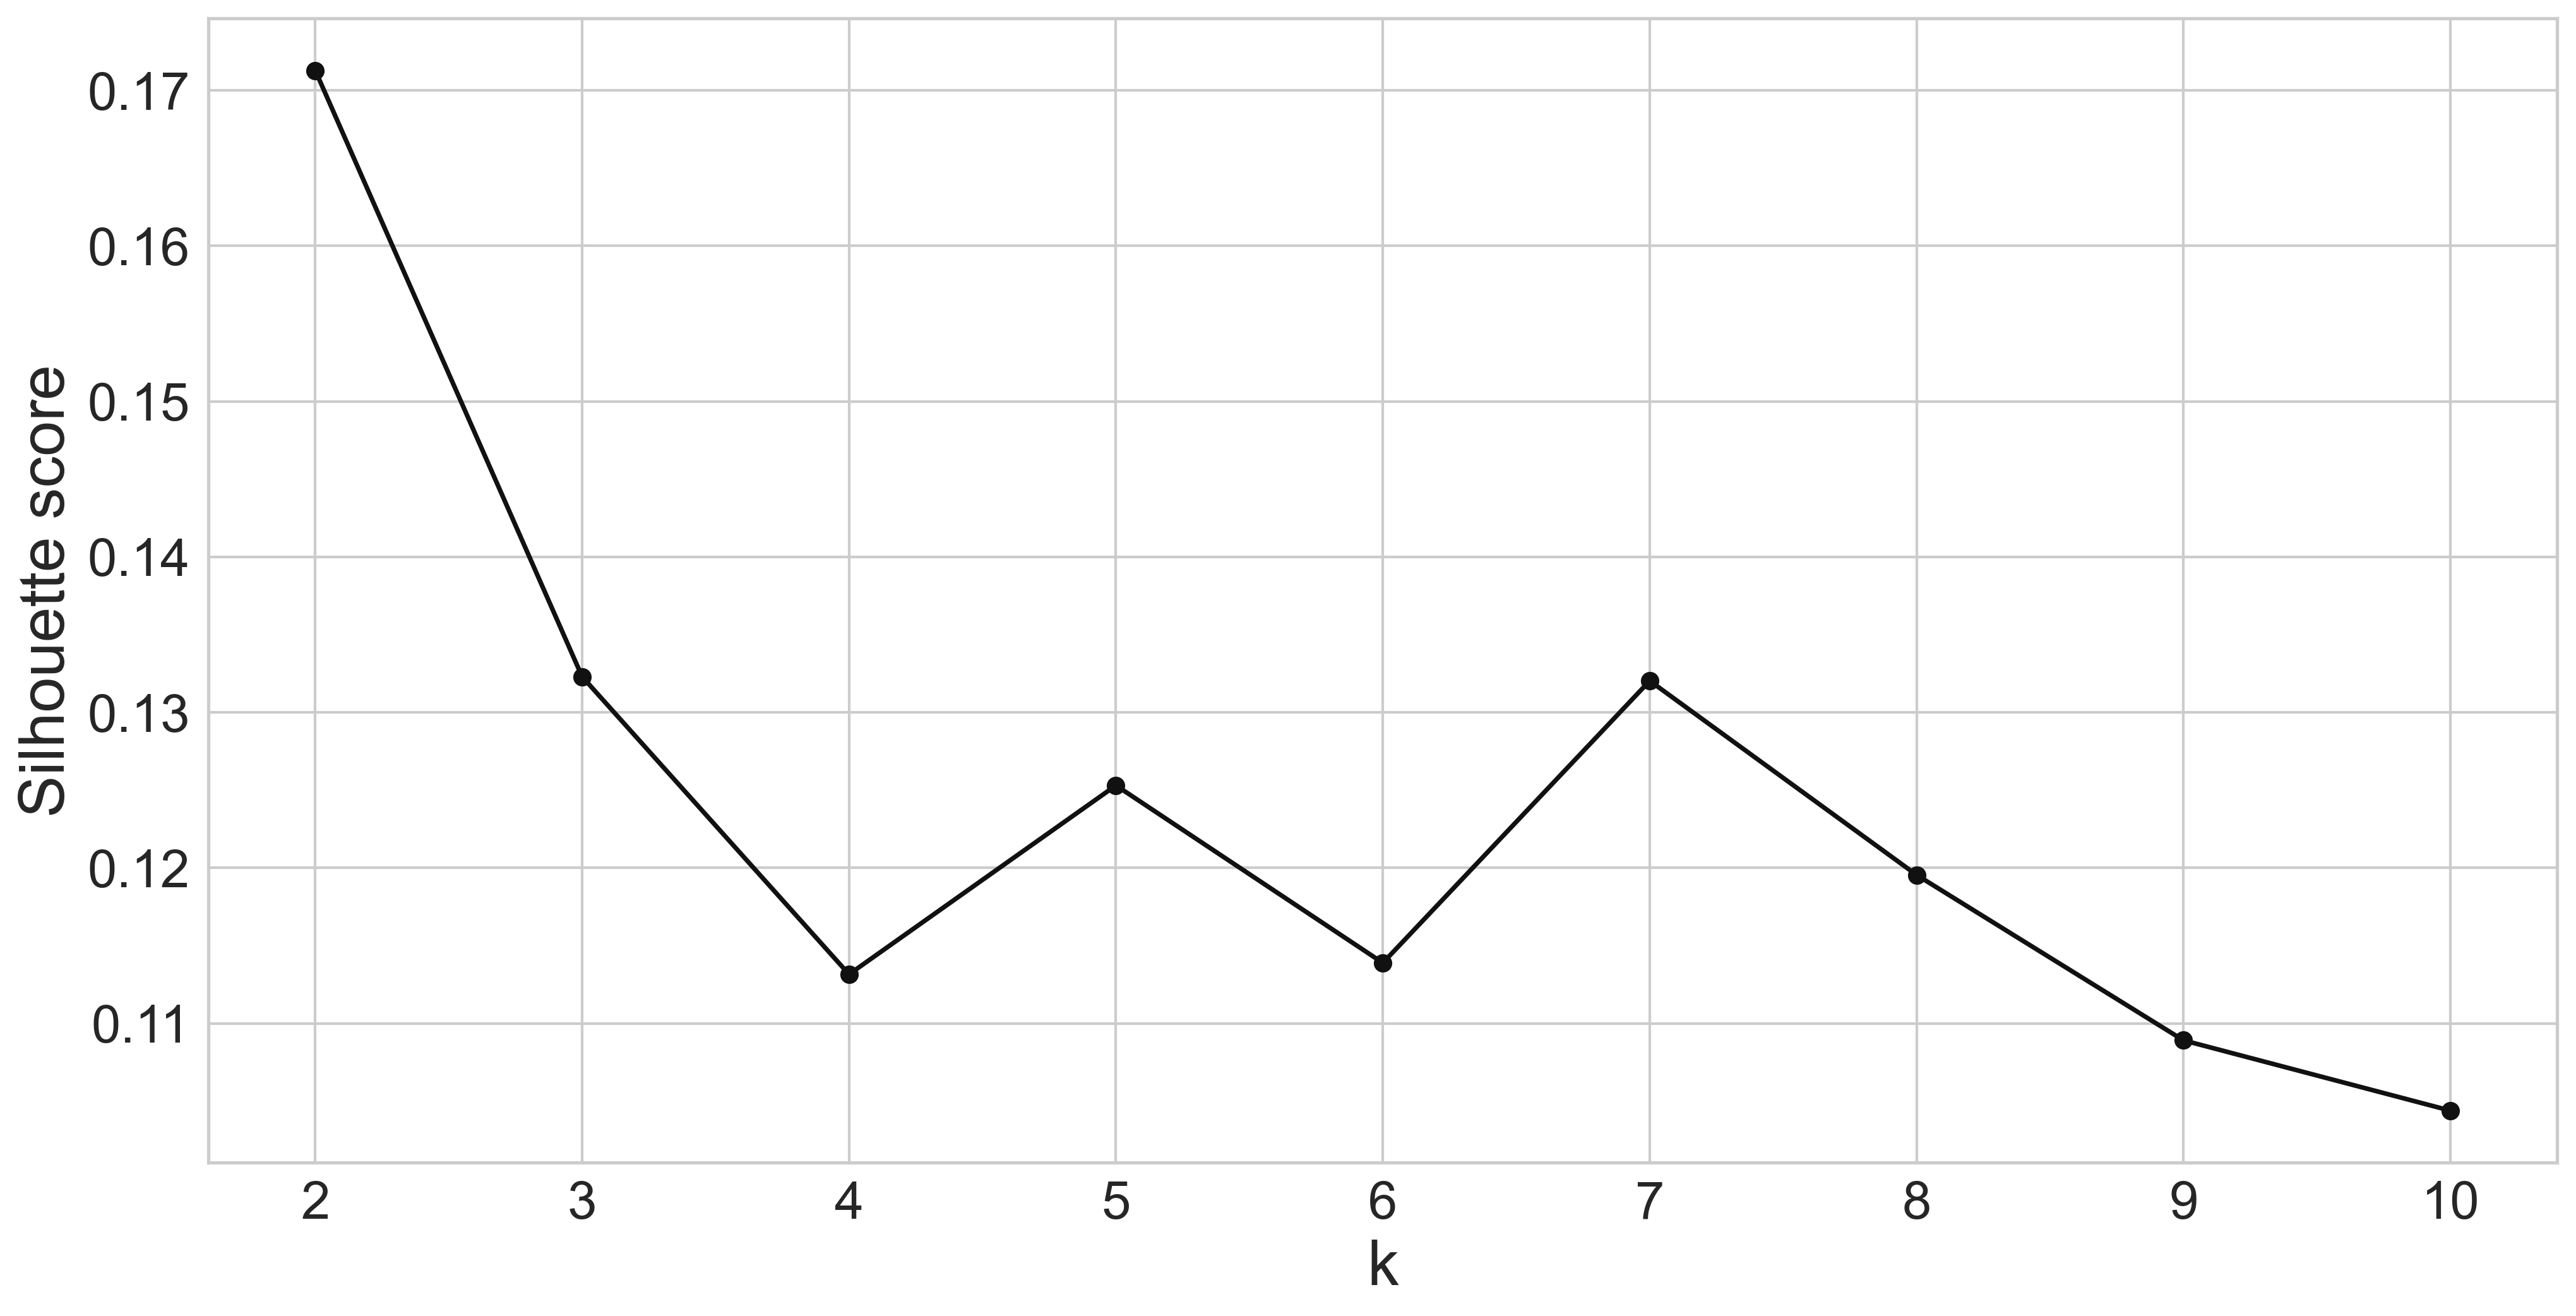

In [6]:
# Create empty list to store Silhouette scores for each k (number of clusters)
S=[]

# Range of number of clusters to compare (2 to 10)
K=range(2,11)

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=3, random_state=3)
    # Fit the model 
    labels = model.fit_predict(LC_data_trans)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(LC_data_trans, labels, metric='mahalanobis'))

# Plot the resulting Silhouette scores on a graph
pyplot.figure(figsize=(16,8), dpi=300)
pyplot.plot(K, S, 'ko-')
pyplot.xlabel('k', fontsize=24)
pyplot.ylabel('Silhouette score', fontsize=24)
pyplot.tick_params(axis='both', labelsize=20)
pyplot.show()

In [ ]:
# Final model
# Specify the number of clusters
num_clusters=5
model = GaussianMixture(n_components=num_clusters, n_init=3, random_state=3)
labels = model.fit_predict(LC_data_trans)

# Add a new column to the original data to save the predicted labels
data["Cluster"] = labels
# Write the DataFrame to a CSV file
#data.to_csv("your_clustered_data_file_name.csv", index=False)

In [20]:
# Colors represent different clusters; Use these colors for all plots
ccode_cl = [PALETTES['flatui'][-3], PALETTES['flatui'][-2], 
            PALETTES['flatui'][-1], PALETTES['flatui'][-4], 
            PALETTES['flatui'][-5]]

# Silhouette score for the final model
sil_av = metrics.silhouette_score(LC_data_trans, labels, metric='mahalanobis')
# Calculate Silhoutte Score for each sample
sil_scrs = metrics.silhouette_samples(LC_data_trans, labels, metric='mahalanobis')

# re-order the sil scores by cluster
n = len(sil_scrs)
ordered = sorted(zip(sil_scrs, labels), key=itemgetter(1), reverse=False)
ordered_sil = [dat for dat, lab in ordered]
ordered_labels = [lab for dat, lab in ordered]

# re-order the sil scores within each cluster in descending order
sil_cl0 = sorted([ordered_sil[i] for i in range(n) if ordered_labels[i] == 0], 
                 reverse=False)
sil_cl1 = sorted([ordered_sil[i] for i in range(n) if ordered_labels[i] == 1], 
                 reverse=False)
sil_cl2 = sorted([ordered_sil[i] for i in range(n) if ordered_labels[i] == 2], 
                 reverse=False)
sil_cl3 = sorted([ordered_sil[i] for i in range(n) if ordered_labels[i] == 3], 
                 reverse=False)
sil_cl4 = sorted([ordered_sil[i] for i in range(n) if ordered_labels[i] == 4], 
                 reverse=False)
# Combine the sil scores for both clusters
sil_cls = [sil_cl0, sil_cl1, sil_cl2, sil_cl3, sil_cl4]

Overall silhouette score for the final model:  0.17453476438035778


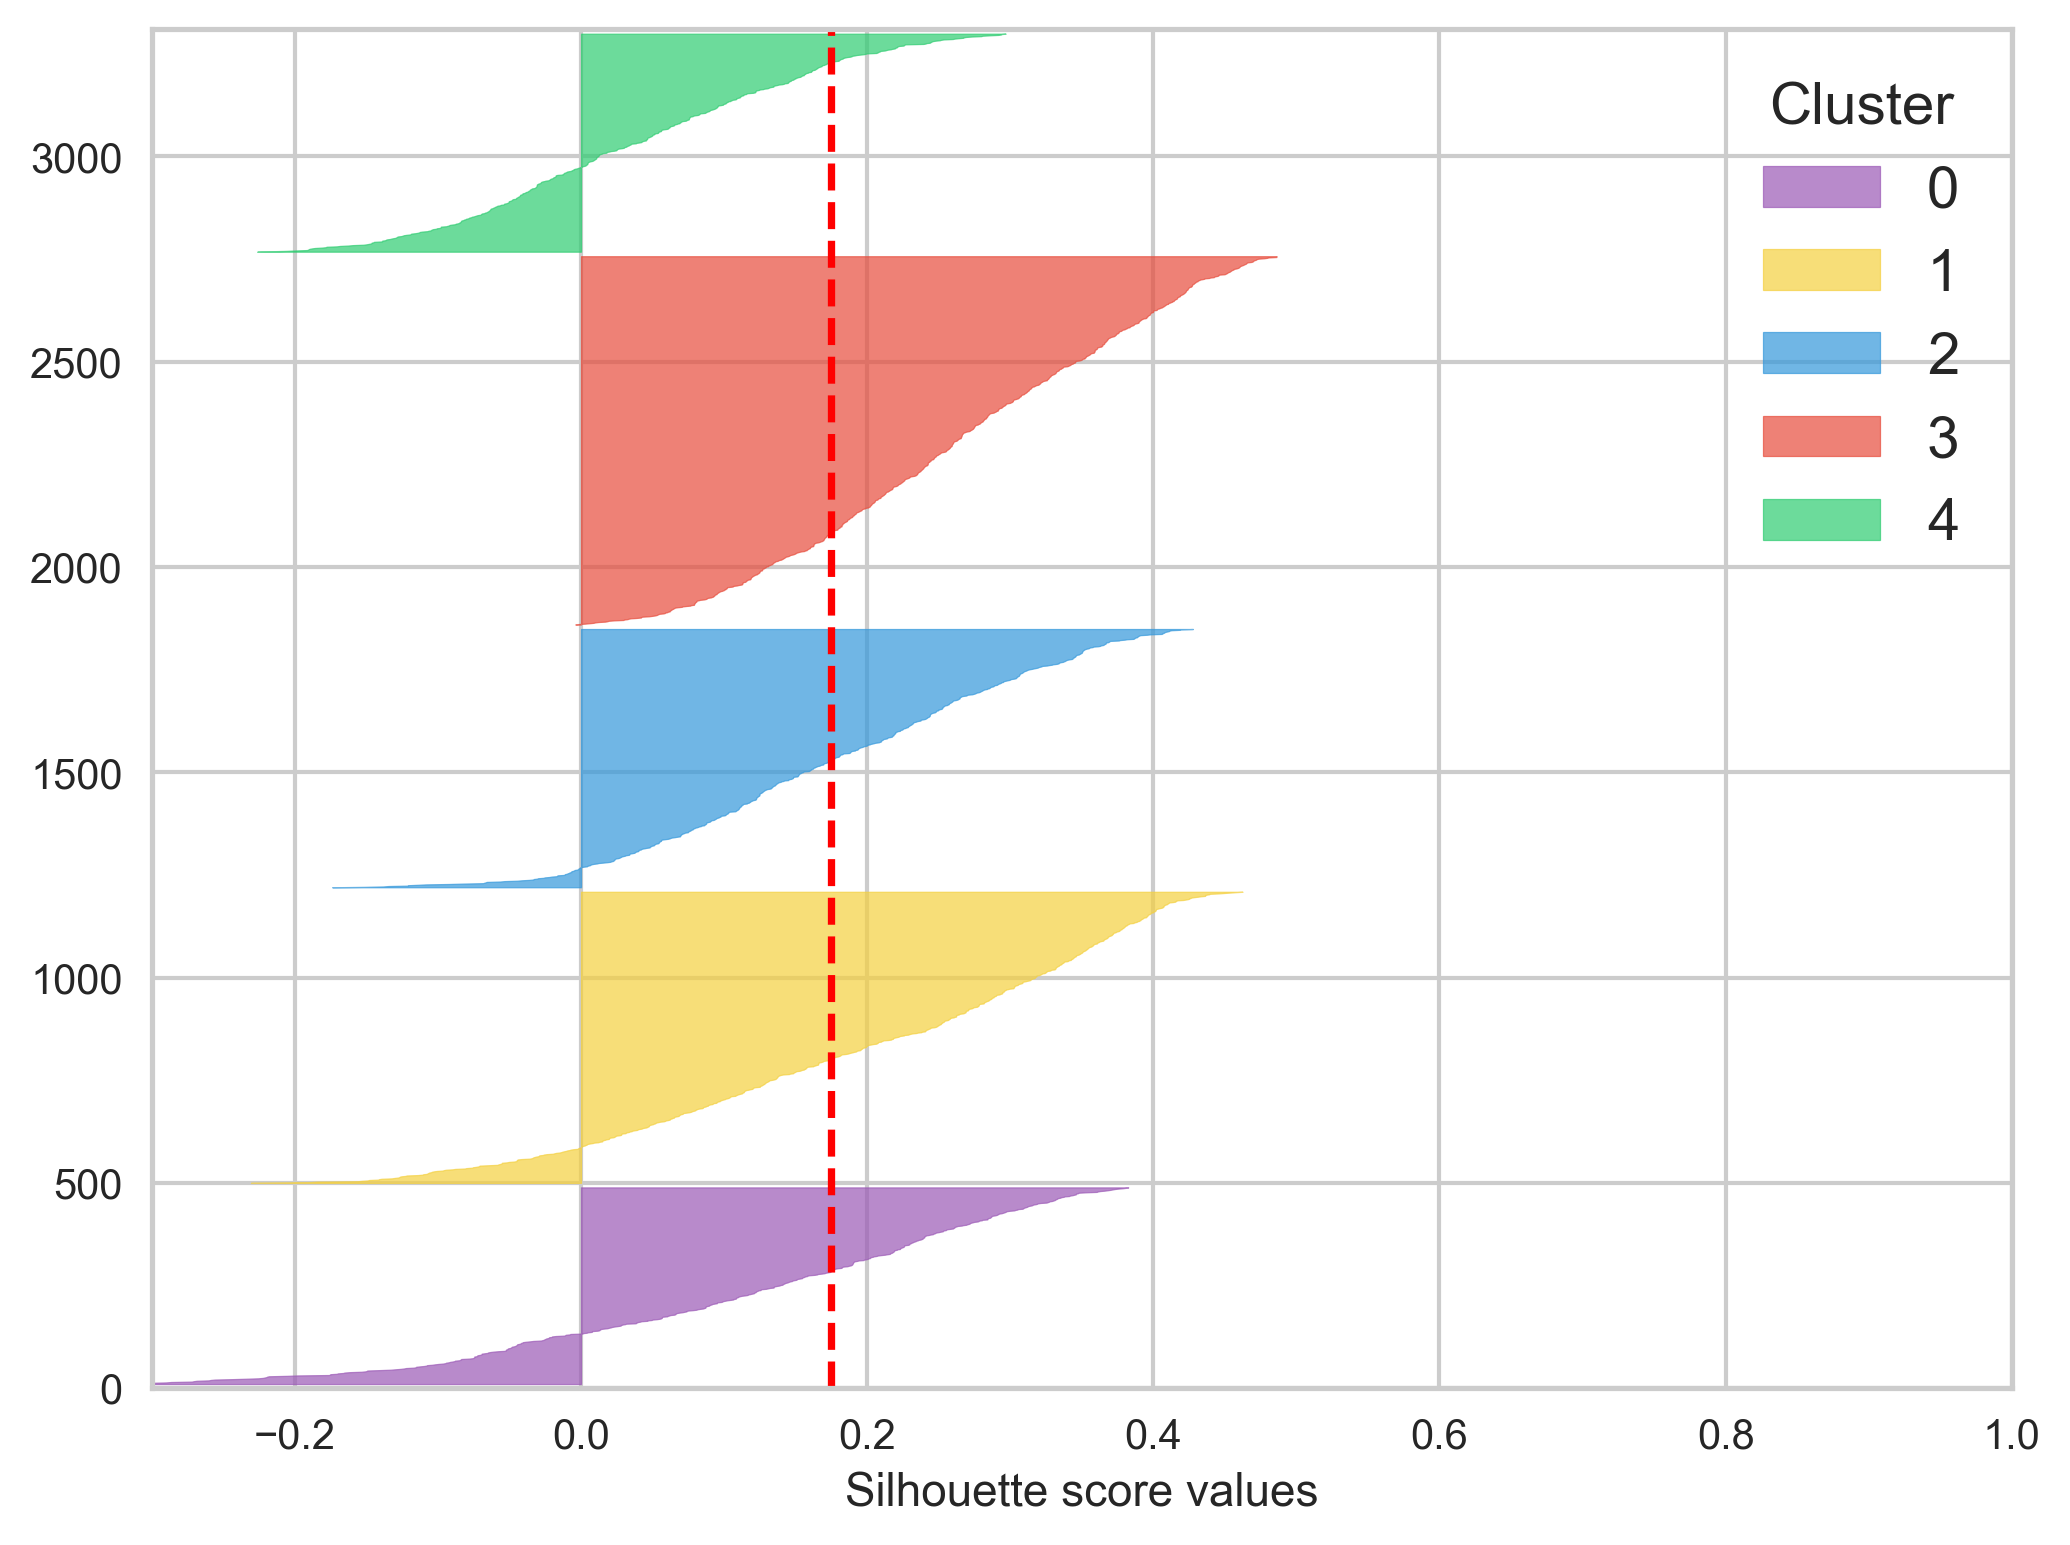

In [17]:
## Plot the silhouette scores
pyplot.figure(figsize=(8,6), dpi=300)

# Set and adjust axes to fit all data points
ax = pyplot.gca()
ax.set_xlim([-0.3, 1])
ax.set_ylim([0, n + (num_clusters + 1) * 10])

# Initial vertical offset for the first cluster
y_lower = 10
# Loop through each cluster to plot silhouette values
for i in range(num_clusters):
    ith_cluster_silhouette_values = sil_cls[i]
    size_cluster_i = len(ith_cluster_silhouette_values)
    y_upper = y_lower + size_cluster_i
    # Plot individual silhouette scores as horizontal bars for the current cluster
    color = ccode_cl[i]
    ax.fill_betweenx(numpy.arange(y_lower, y_upper), # y range
                     0, # starting x value
                     ith_cluster_silhouette_values, 
                     facecolor=color, 
                     edgecolor=color, 
                     alpha=0.7)
    # Upandasate the vertical offset for the next cluster
    y_lower = y_upper + 10

# Set x-axis labels
ax.set_xlabel("Silhouette score values")
# Add vertical line to show the average silhouette score
print("Overall silhouette score for the final model: ", sil_av)
ax.axvline(x=sil_av, color="red", linestyle="--")
# Add lengend
ax.legend([str(i) for i in range(num_clusters)], loc="upper right",
          fontsize=14, title="Cluster", title_fontsize=14)
pyplot.show()

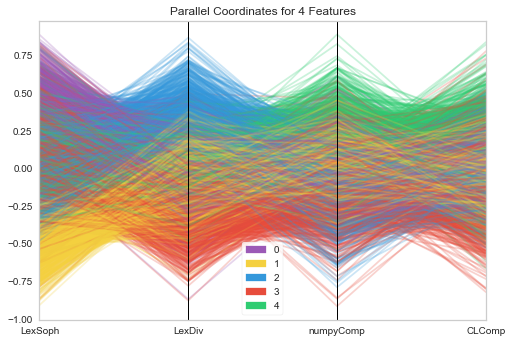

<AxesSubplot:title={'center':'Parallel Coordinates for 4 Features'}>

In [21]:
## Parallel coordinates
pc = ParallelCoordinates(classes=sorted(numpy.unique(labels)), 
              features=["LexSoph", "LexDiv", "numpyComp", "CLComp"], 
              normalize="l1", colors=ccode_cl, shuffle=True, 
              random_state=3, 
              dpi=300)
pc.fit(LC_data_trans, labels)
pc.show()

In [22]:
# Create a contingency table
contingency_table = pandas.crosstab(data['Score'], data['Cluster'])
print(contingency_table)

Cluster    0    1    2    3    4
Score                           
2        174  477  220  431  256
3        227  211  355  419  224
4         79   22   55   48   52


In [23]:
# Perform Chi-squared test
chi2, p, df, expected = chi2_contingency(contingency_table)
print("Chi-squared test statistic:", round(chi2, 2))
print("p-value:", p)
print("Degrees of freedom:", df)

Chi-squared test statistic: 224.12
p-value: 5.175510565470877e-44
Degrees of freedom: 8


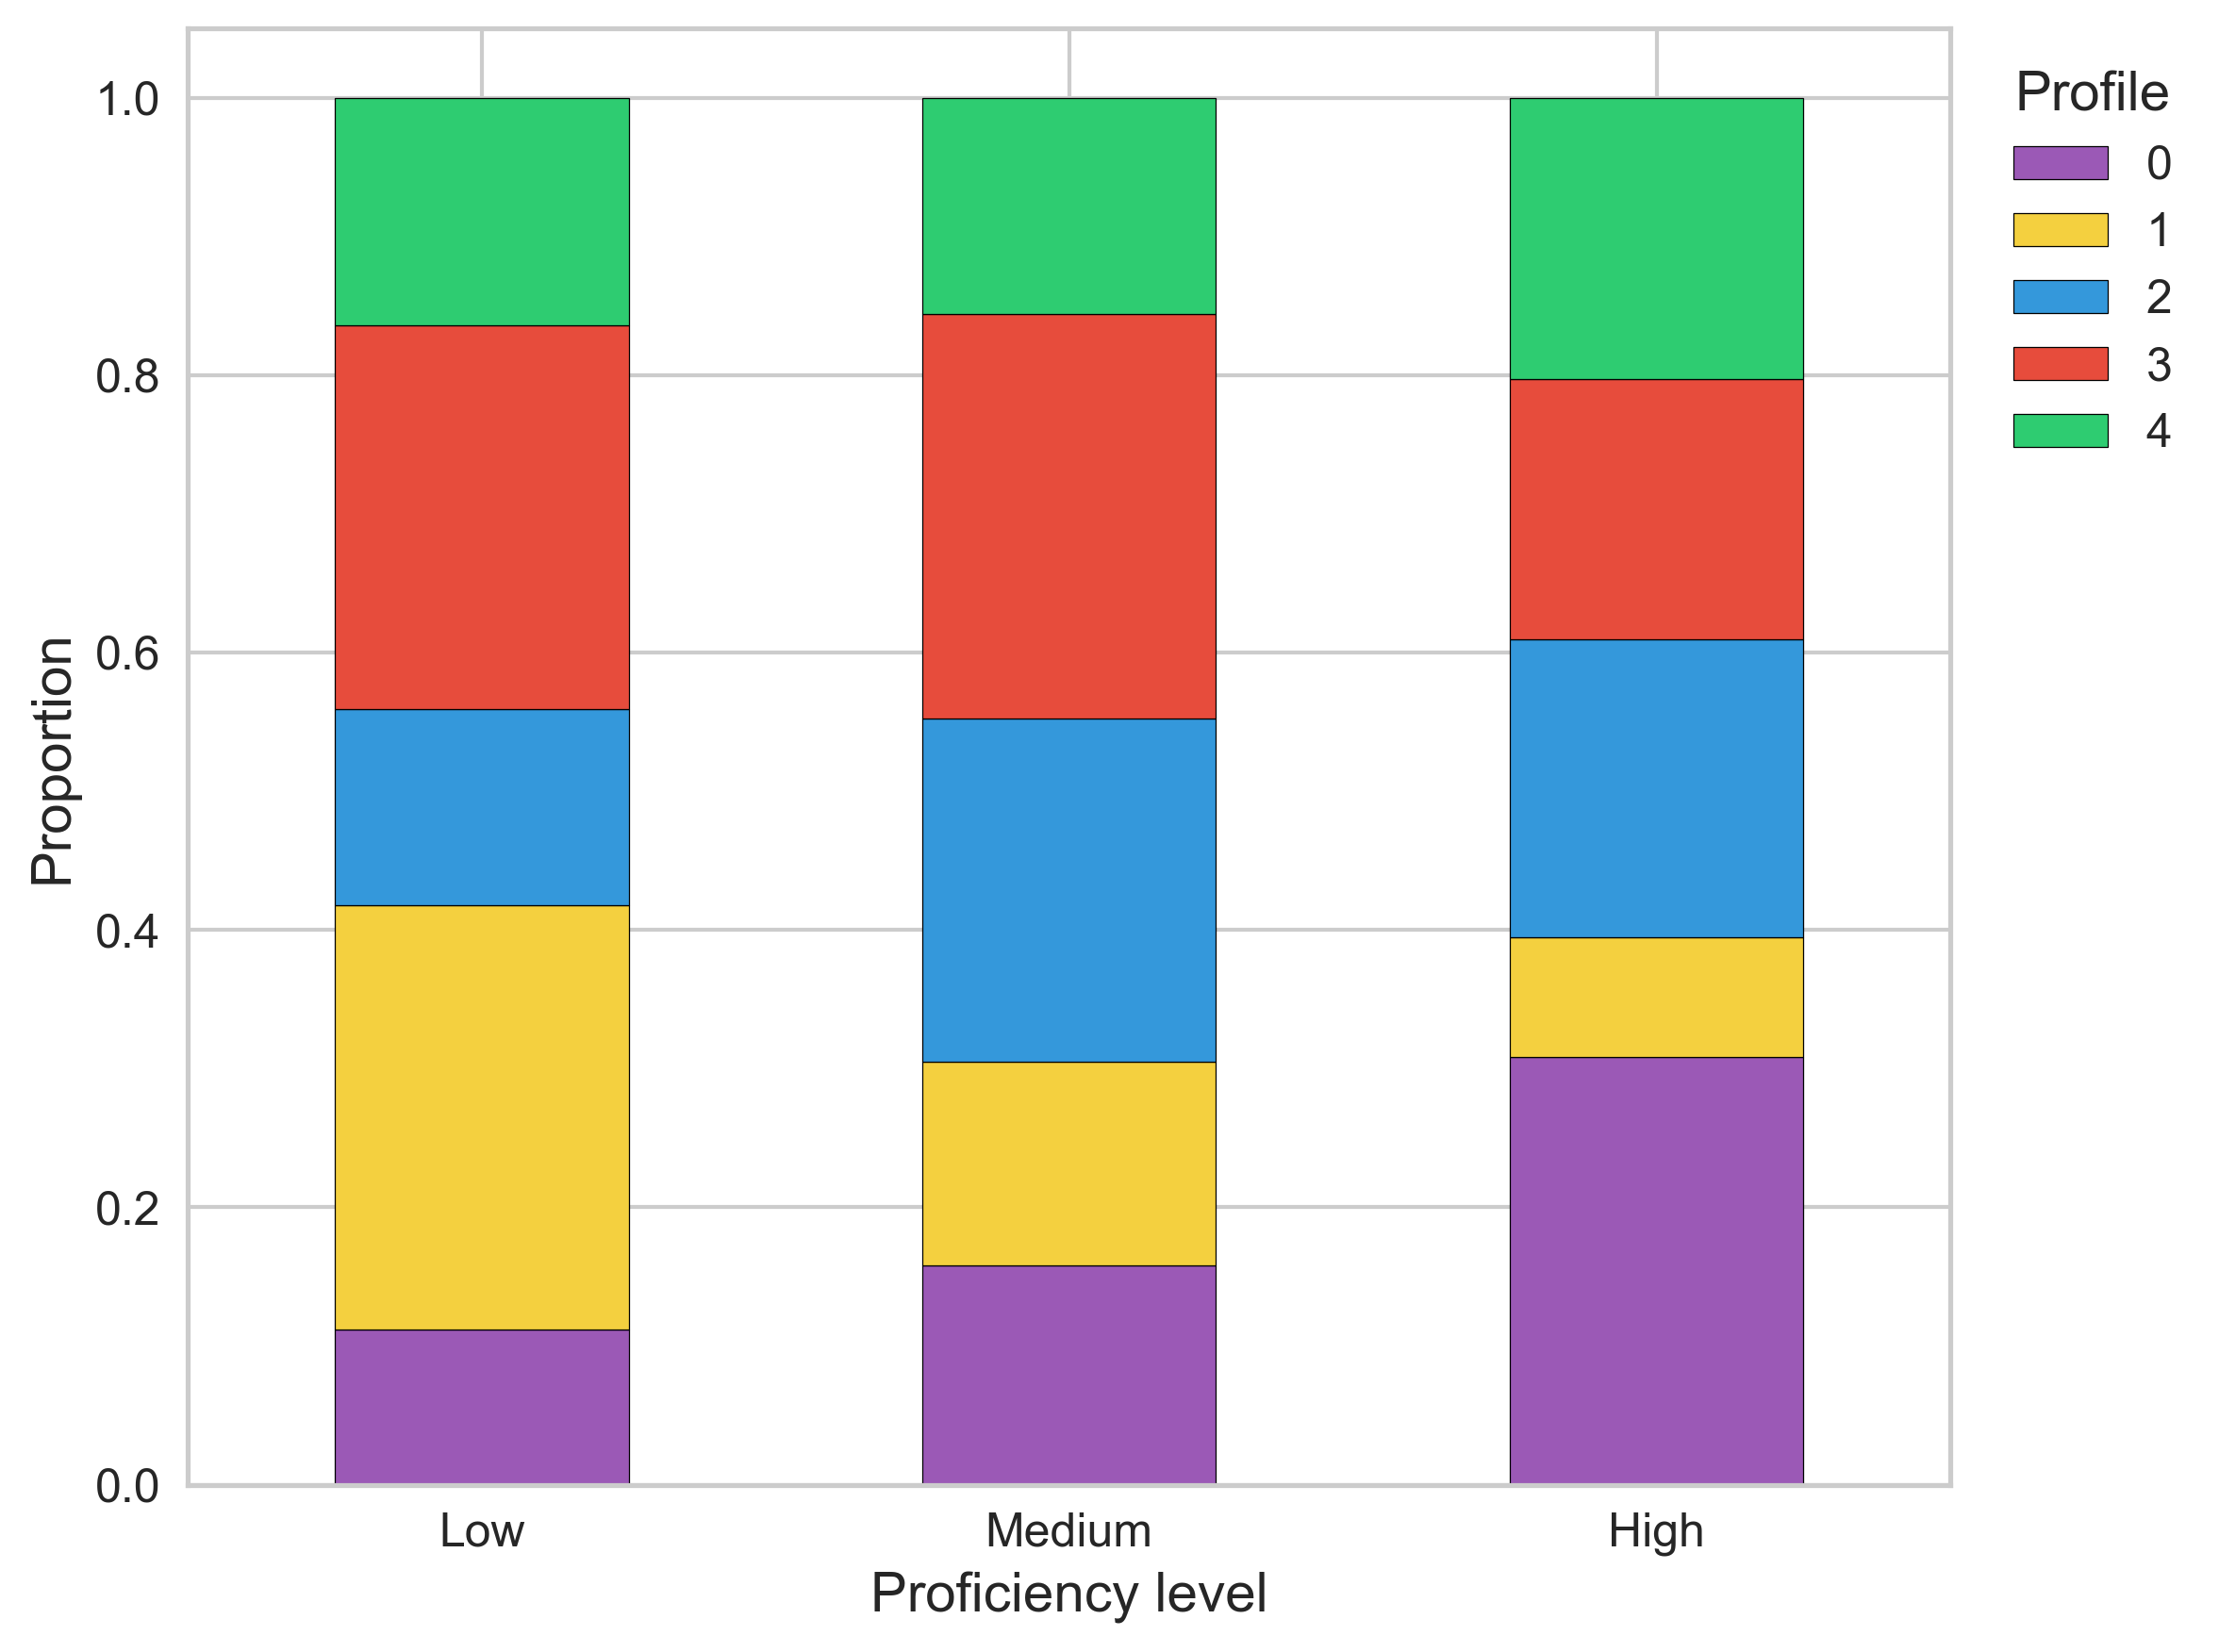

In [24]:
# Plot a stacked bar chart of profile by proficiency level using proportion
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
fig, ax = pyplot.subplots(figsize=(8, 6), dpi=300)
proportions.plot(kind='bar', stacked=True, color=ccode_cl, 
                        figsize=(8, 6), edgecolor='black', ax=ax)  
ax.set_xlabel("Proficiency level", fontsize=14)
ax.set_ylabel("Proportion", fontsize=14)
ax.set_xticklabels(["Low", "Medium", "High"], fontsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)
ax.legend(title="Profile", loc='upper right', bbox_to_anchor=(1.15, 1),
    fontsize=12, title_fontsize=14)
pyplot.tight_layout()
pyplot.show()